# Transfer Learning with TensorFlow using Food101 dataset

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/ 

Food101 dataset: https://www.kaggle.com/dansbecker/food-101 

In [1]:
# check GPU
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1660 (UUID: GPU-92a68937-bbf0-a1fb-dfe4-931edc9e416d)


## Tensorflow Mixed Precision

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

In [3]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


In [4]:
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


## Import helper functions

helper_functions.py by Daniel Bourke https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

In [5]:
import helper_functions

## Pre-processing data

Pre-processing Food 101 Dataset from kaggle

Link: https://www.kaggle.com/dansbecker/food-101  

In [6]:
# get the data

train_dir = "../../data/all_food_classes/train/"
test_dir = "../../data/all_food_classes/test/"

In [7]:
# How many images/classes are there?
helper_functions.walk_through_dir("../../data/all_food_classes")

There are 2 directories and 0 images in '../../data/all_food_classes'.
There are 101 directories and 0 images in '../../data/all_food_classes\test'.
There are 0 directories and 250 images in '../../data/all_food_classes\test\apple_pie'.
There are 0 directories and 250 images in '../../data/all_food_classes\test\baby_back_ribs'.
There are 0 directories and 250 images in '../../data/all_food_classes\test\baklava'.
There are 0 directories and 250 images in '../../data/all_food_classes\test\beef_carpaccio'.
There are 0 directories and 250 images in '../../data/all_food_classes\test\beef_tartare'.
There are 0 directories and 250 images in '../../data/all_food_classes\test\beet_salad'.
There are 0 directories and 250 images in '../../data/all_food_classes\test\beignets'.
There are 0 directories and 250 images in '../../data/all_food_classes\test\bibimbap'.
There are 0 directories and 250 images in '../../data/all_food_classes\test\bread_pudding'.
There are 0 directories and 250 images in '..

In [8]:
# Setup data inputs

IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                validation_split=0.2,
                                                                seed=42,
                                                                subset='training')                                                            
                                                                                
validation_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                     label_mode="categorical",
                                                                     image_size=IMG_SIZE,
                                                                     validation_split=0.2,
                                                                     seed=42,
                                                                     subset='validation')
                                                                     
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 75750 files belonging to 101 classes.
Using 60600 files for training.
Found 75750 files belonging to 101 classes.
Using 15150 files for validation.
Found 25250 files belonging to 101 classes.


In [9]:
train_data.class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Preview Dataset (Sample)

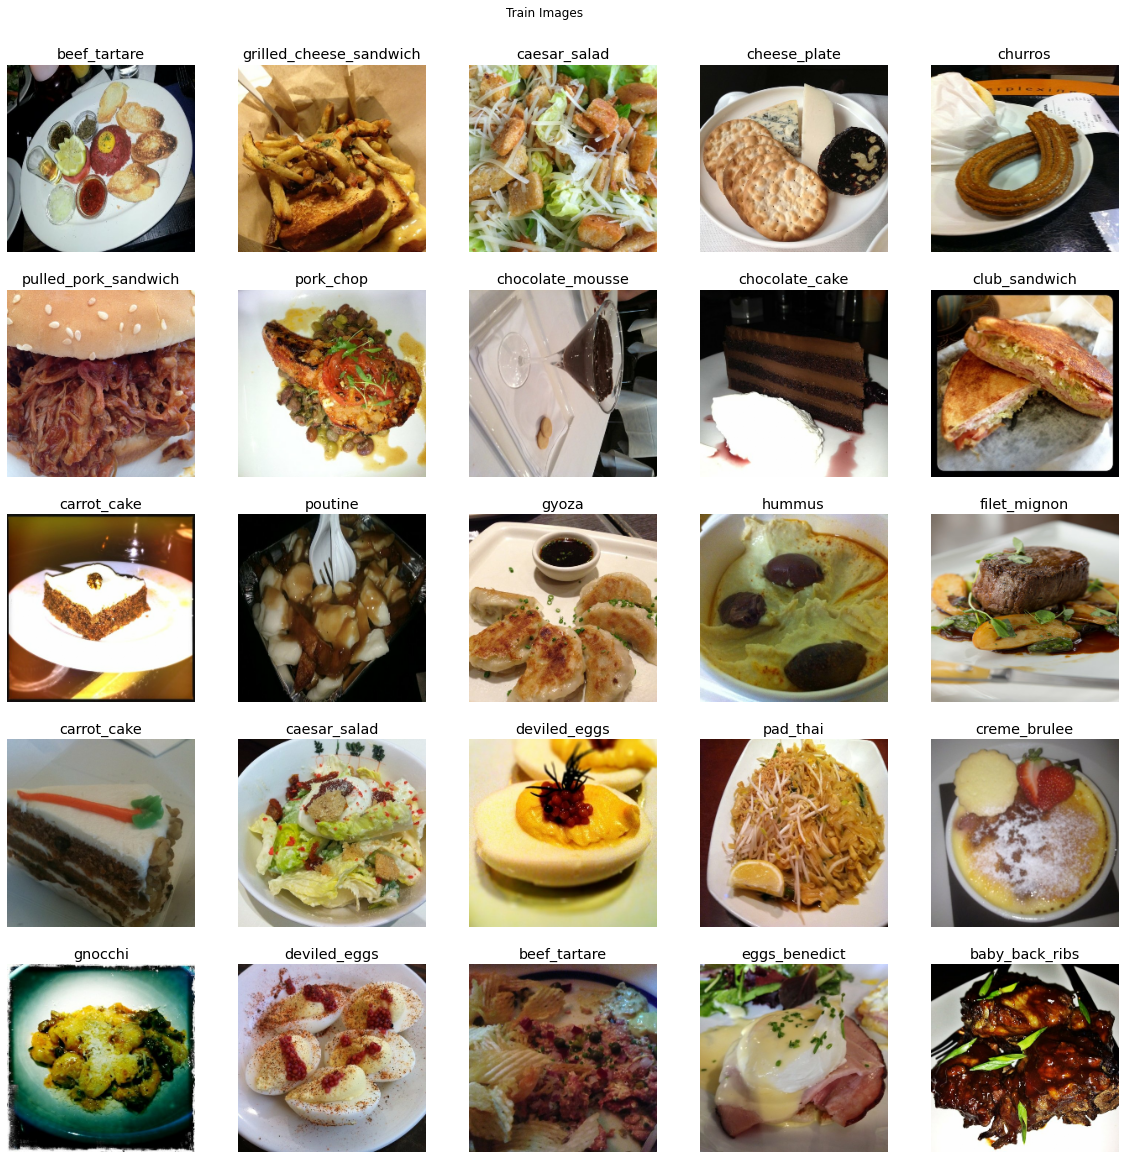

In [10]:
import matplotlib.pyplot as plt 
import os
import random

# Random sample images from train_dir
fig = plt.figure(figsize=(20, 20))

for i in range(25):
    plt.suptitle("Train Images", y=0.92)
    plt.subplot(5, 5, i+1)
    # Choose a random image from a random class 
    class_name = random.choice(train_data.class_names)
    filename = random.choice(os.listdir(train_dir + "/" + class_name))
    filepath = train_dir + class_name + "/" + filename

    img = helper_functions.load_and_prep_image(filepath, scale=True)
    plt.imshow(img, cmap='gray')
    plt.title(f"{class_name}")
    plt.axis('off')

plt.show()

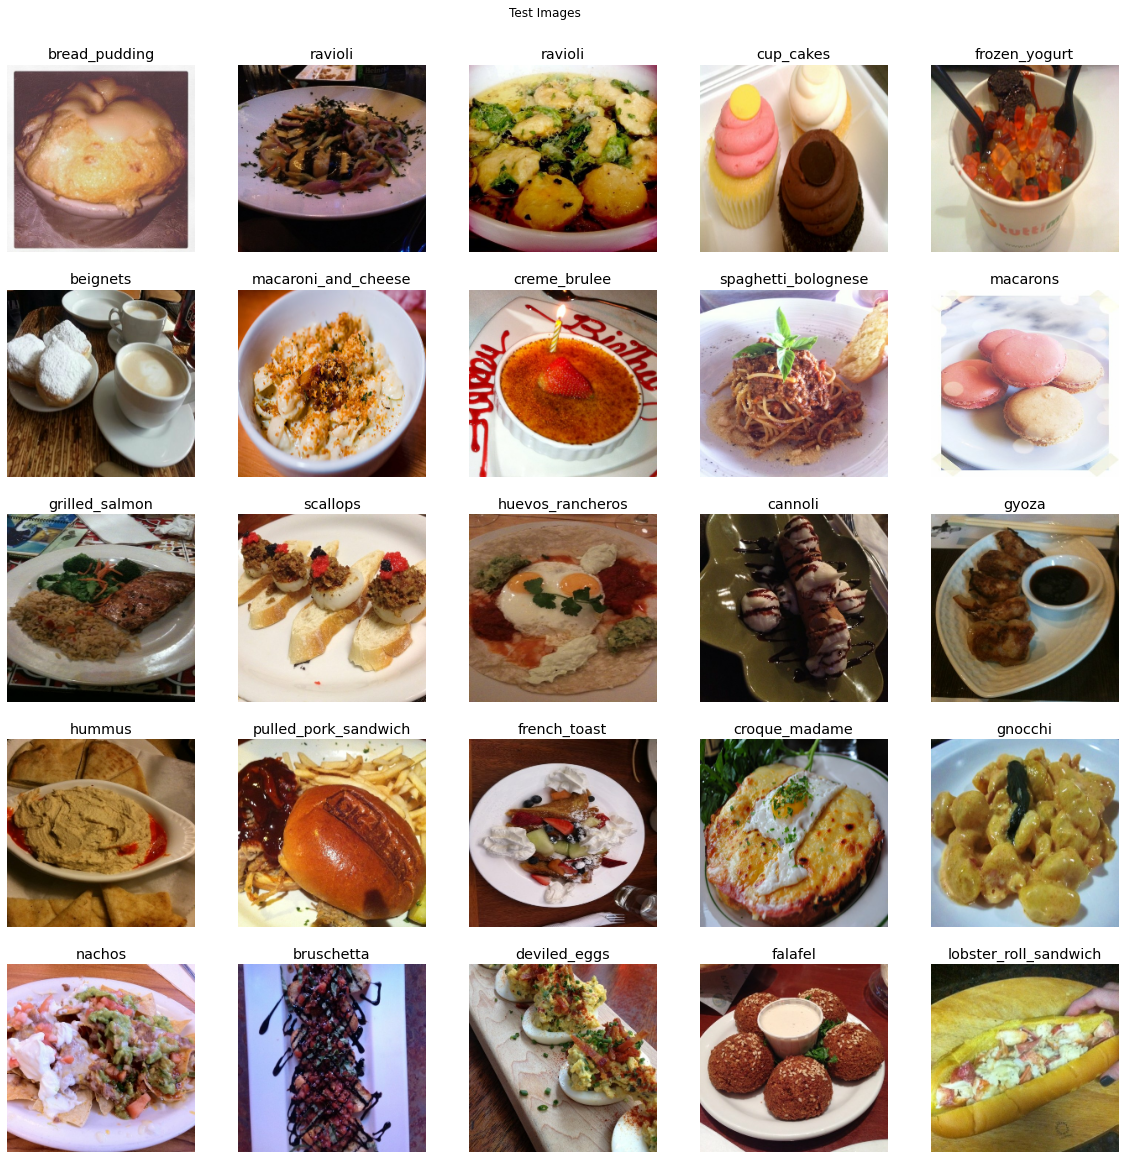

In [11]:
# Random sample images from test_dir
fig = plt.figure(figsize=(20, 20))

for i in range(25):
    plt.suptitle("Test Images", y=0.92)
    plt.subplot(5, 5, i+1)
    # Choose a random image from a random class 
    class_name = random.choice(test_data.class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + class_name + "/" + filename

    img = helper_functions.load_and_prep_image(filepath, scale=True)
    plt.imshow(img, cmap='gray')
    plt.title(f"{class_name}")
    plt.axis('off')

plt.show()

# Training Food101 

- Using Model Architecture: Inception-ResNet v2 

## 3 Steps model
1. Feature Extraction without Augmentation (Only train output layer)
2. Feature Extraction plus Dense and Dropout with Augmentation
3. Fine Tune last 10 layers with 0.0001 Learning Rate

### Reference: 
- [TF-Keras Applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_resnet_v2/InceptionResNetV2)
- [Arxiv Paper](https://arxiv.org/abs/1602.07261)

## Data Augmentation

In [12]:
## Data augmentation

# Setup data augmentation
data_augmentation = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2), # randomly zoom into an image
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255) 
], name="data_augmentation")

## Create a Callbacks object

In [13]:
# Create checkpoint callback to save model for later use
checkpoint_path = "checkpoint/food101_model_checkpoint"
checkpoint_callback_notrain = tf.keras.callbacks.ModelCheckpoint(checkpoint_path + "_notrain",
                                                                save_weights_only=True, # save only the model weights
                                                                monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                                save_best_only=True)

checkpoint_callback_dense = tf.keras.callbacks.ModelCheckpoint(checkpoint_path + "_dense",
                                                              save_weights_only=True, # save only the model weights
                                                              monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                              save_best_only=True)                                                        

checkpoint_callback_finetune = tf.keras.callbacks.ModelCheckpoint(checkpoint_path + "_finetune",
                                                                 save_weights_only=True, # save only the model weights
                                                                 monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                                 save_best_only=True)    

tensorboard_callback_notrain = helper_functions.create_tensorboard_callback("training_logs", "Food101_notrain")

tensorboard_callback_dense = helper_functions.create_tensorboard_callback("training_logs", "Food101_dense")

tensorboard_callback_finetune = helper_functions.create_tensorboard_callback("training_logs", "Food101_finetune")

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3)


# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

Saving TensorBoard log files to: training_logs/Food101_notrain/20210730-120615
Saving TensorBoard log files to: training_logs/Food101_dense/20210730-120615
Saving TensorBoard log files to: training_logs/Food101_finetune/20210730-120615


In [14]:
# Create model
input_shape = (224, 224, 3)

# Create base model
base_model = tf.keras.applications.InceptionResNetV2(include_top=False)
base_model.trainable = False

# Functional model
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = tf.keras.layers.Dense(len(train_data.class_names), name='dense101')(x)
outputs = tf.keras.layers.Activation(
    "softmax",
    dtype=tf.float32,
    name="softmax_float32")(x)

model_notrain = tf.keras.Model(inputs, outputs)

In [15]:
# Compile the model
model_notrain.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [16]:
model_notrain.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, None, None, 1536)  54336736  
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1536)              0         
_________________________________________________________________
dense101 (Dense)             (None, 101)               155237    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 54,491,973
Trainable params: 155,237
Non-trainable params: 54,336,736
_________________________________________________________________


In [17]:
# Check the dtype_policy attributes of layers in our model
for layer in model_notrain.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) 

input_layer True float32 <Policy "float32">
inception_resnet_v2 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense101 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [18]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model_notrain.layers[1].layers[:10]: # only check the first 10
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
conv2d False float32 <Policy "mixed_float16">
batch_normalization False float32 <Policy "mixed_float16">
activation False float32 <Policy "mixed_float16">
conv2d_1 False float32 <Policy "mixed_float16">
batch_normalization_1 False float32 <Policy "mixed_float16">
activation_1 False float32 <Policy "mixed_float16">
conv2d_2 False float32 <Policy "mixed_float16">
batch_normalization_2 False float32 <Policy "mixed_float16">
activation_2 False float32 <Policy "mixed_float16">


## 1. Fit Model No Train (Feature Extraction without Augmentation)

In [19]:
history_notrain = model_notrain.fit(train_data,
                                    epochs=10,
                                    steps_per_epoch=len(train_data),
                                    validation_data=validation_data,
                                    callbacks=[checkpoint_callback_notrain, tensorboard_callback_notrain, early_stopping, reduce_lr])

Epoch 1/10
1894/1894 [==============================] - 3131s 2s/step - loss: 365.1637 - accuracy: 0.0102 - val_loss: 287.0685 - val_accuracy: 0.0119
Epoch 2/10
1894/1894 [==============================] - 2423s 1s/step - loss: 308.5200 - accuracy: 0.0127 - val_loss: 278.4592 - val_accuracy: 0.0130
Epoch 3/10
1894/1894 [==============================] - 1618s 854ms/step - loss: 301.8448 - accuracy: 0.0137 - val_loss: 287.7302 - val_accuracy: 0.0111
Epoch 4/10
1894/1894 [==============================] - 1927s 1s/step - loss: 292.8427 - accuracy: 0.0125 - val_loss: 260.1462 - val_accuracy: 0.0122
Epoch 5/10
1894/1894 [==============================] - 1697s 896ms/step - loss: 296.3961 - accuracy: 0.0136 - val_loss: 253.8958 - val_accuracy: 0.0142
Epoch 6/10
1894/1894 [==============================] - 1808s 954ms/step - loss: 286.1164 - accuracy: 0.0139 - val_loss: 324.6453 - val_accuracy: 0.0094
Epoch 7/10
1894/1894 [==============================] - 1619s 855ms/step - loss: 289.9551 -

In [20]:
# evaluate
model_notrain.evaluate(test_data)

790/790 [==============================] - 879s 1s/step - loss: 23.9941 - accuracy: 0.0153


[23.994081497192383, 0.015326732769608498]

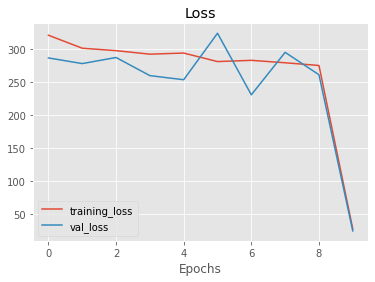

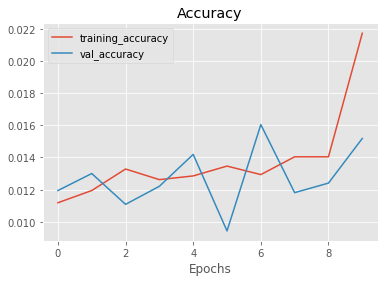

In [21]:
helper_functions.plot_loss_curves(history_notrain)

In [22]:
# save model

model_notrain.save("model/model_notrain.h5")
model_notrain.save("model/model_notrain")

INFO:tensorflow:Assets written to: model/model_notrain\assets


## 2. Add Dense and Dropout Layer Fit with Augmentation

In [23]:
# Functional model
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = tf.keras.layers.Dense(1024, name='hidden_dense_1')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout_1')(x)
x = tf.keras.layers.Dense(512, name='hidden_dense_2')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout_2')(x)
x = tf.keras.layers.Dense(256, name='hidden_dense_3')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout_3')(x)
x = tf.keras.layers.Dense(len(train_data.class_names), name='dense101')(x)
outputs = tf.keras.layers.Activation(
    "softmax",
    dtype=tf.float32,
    name="softmax_float32")(x)

model_dense = tf.keras.Model(inputs, outputs)

In [24]:
# Compile the model
model_dense.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

model_dense.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, None, None, 1536)  54336736  
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1536)              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 1024)              1573888   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 512)               5248

In [25]:
history_dense = model_dense.fit(train_data,
                                epochs=20,
                                steps_per_epoch=len(train_data),
                                validation_data=validation_data,
                                callbacks=[checkpoint_callback_dense, tensorboard_callback_dense, early_stopping, reduce_lr])

Epoch 1/20
1894/1894 [==============================] - 3338s 2s/step - loss: 5.2985 - accuracy: 0.1780 - val_loss: 2.8593 - val_accuracy: 0.3428
Epoch 2/20
1894/1894 [==============================] - 2782s 1s/step - loss: 3.2868 - accuracy: 0.2747 - val_loss: 2.7389 - val_accuracy: 0.3444
Epoch 3/20
1894/1894 [==============================] - 2530s 1s/step - loss: 3.1383 - accuracy: 0.2876 - val_loss: 2.7543 - val_accuracy: 0.3441
Epoch 4/20
1894/1894 [==============================] - 2056s 1s/step - loss: 3.1434 - accuracy: 0.2840 - val_loss: 2.9864 - val_accuracy: 0.3065

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/20
1894/1894 [==============================] - 2969s 2s/step - loss: 2.5063 - accuracy: 0.3910 - val_loss: 2.0306 - val_accuracy: 0.4830
Epoch 6/20
1894/1894 [==============================] - 2072s 1s/step - loss: 2.3264 - accuracy: 0.4290 - val_loss: 2.0211 - val_accuracy: 0.4837
Epoch 7/20
1894/1894 [====================

In [26]:
# evaluate
model_dense.evaluate(test_data)

790/790 [==============================] - 1087s 1s/step - loss: 1.5297 - accuracy: 0.5888


[1.529664158821106, 0.5887524485588074]

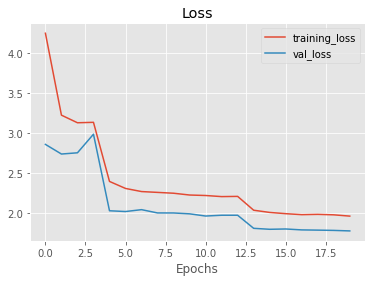

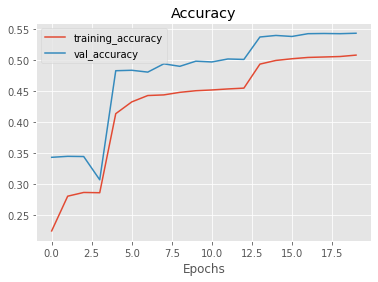

In [27]:
helper_functions.plot_loss_curves(history_dense)

In [28]:
# save model

model_dense.save("model/model_dense.h5")
model_dense.save("model/model_dense")

INFO:tensorflow:Assets written to: model/model_dense\assets


## 3. Fine tuning (Unfreeze last 50 layers)


In [29]:
tf.keras.backend.clear_session()

In [30]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 50
for layer in base_model.layers[:-50]:
  layer.trainable = False

In [31]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed_5b False
41 conv2d_15 False
42 batch_normalization_15 Fal

In [32]:
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = tf.keras.layers.Dense(1024, name='hidden_dense_1')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout_1')(x)
x = tf.keras.layers.Dense(512, name='hidden_dense_2')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout_2')(x)
x = tf.keras.layers.Dense(256, name='hidden_dense_3')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout_3')(x)
x = tf.keras.layers.Dense(len(train_data.class_names), name='dense101')(x)
outputs = tf.keras.layers.Activation(
    "softmax",
    dtype=tf.float32,
    name="softmax_float32")(x)


model_finetune = tf.keras.Model(inputs, outputs)


In [33]:
model_finetune.compile(loss="categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
                      metrics=["accuracy"])

model_finetune.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, None, None, 1536)  54336736  
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1536)              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 1024)              1573888   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 512)               524800

In [34]:
# train fine tuned model
history_finetune = model_finetune.fit(train_data,
                                     epochs=20,
                                     steps_per_epoch=len(train_data),
                                     validation_data=validation_data,
                                     callbacks=[checkpoint_callback_finetune, tensorboard_callback_finetune, early_stopping, reduce_lr])

Epoch 1/20
1894/1894 [==============================] - 3637s 2s/step - loss: 3.3463 - accuracy: 0.2402 - val_loss: 1.8822 - val_accuracy: 0.5220
Epoch 2/20
1894/1894 [==============================] - 2459s 1s/step - loss: 2.1001 - accuracy: 0.4743 - val_loss: 1.6571 - val_accuracy: 0.5747
Epoch 3/20
1894/1894 [==============================] - 2465s 1s/step - loss: 1.8264 - accuracy: 0.5349 - val_loss: 1.5898 - val_accuracy: 0.5998
Epoch 4/20
1894/1894 [==============================] - 2708s 1s/step - loss: 1.6577 - accuracy: 0.5730 - val_loss: 1.4848 - val_accuracy: 0.6226
Epoch 5/20
1894/1894 [==============================] - 2906s 2s/step - loss: 1.5193 - accuracy: 0.6042 - val_loss: 1.4642 - val_accuracy: 0.6308
Epoch 6/20
1894/1894 [==============================] - 2579s 1s/step - loss: 1.3986 - accuracy: 0.6315 - val_loss: 1.4280 - val_accuracy: 0.6405
Epoch 7/20
1894/1894 [==============================] - 2446s 1s/step - loss: 1.3110 - accuracy: 0.6512 - val_loss: 1.4295 -

In [35]:
# evaluate
model_finetune.evaluate(test_data)

790/790 [==============================] - 875s 1s/step - loss: 1.1104 - accuracy: 0.7242


[1.1103934049606323, 0.7242376208305359]

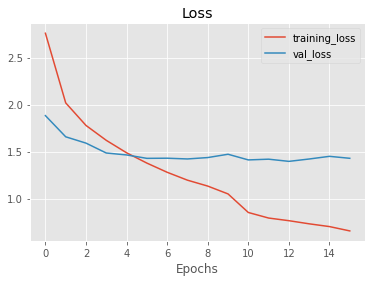

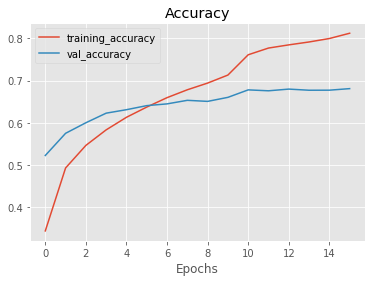

In [36]:
helper_functions.plot_loss_curves(history_finetune)

In [37]:
# save model

model_finetune.save("model/model_finetune.h5")
model_finetune.save("model/model_finetune")

INFO:tensorflow:Assets written to: model/model_finetune\assets
